In [1]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import sys

from albumentations.pytorch.transforms import ToTensorV2
from effdet import default_detection_model_configs, load_checkpoint, load_pretrained, EfficientDet, \
                   DetBenchTrain
from effdet.config.model_config import efficientdet_model_param_dict
from omegaconf import OmegaConf
from pathlib import Path
from PIL import Image
from torch import Tensor

In [2]:
sys.path.append('../src')

In [3]:
from data.dataset import WheatDataset
from data.utils import basic_collate

In [4]:
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

DATA_DIR = Path('/media/dmitry/data/global-wheat-detection')

In [5]:
def get_efficientdet_config(model_name='tf_efficientdet_d1'):
    """Get the default config for EfficientDet based on model name."""
    config = default_detection_model_configs()
    config.num_classes = 1
    model_config = efficientdet_model_param_dict[model_name]
    return OmegaConf.merge(config, OmegaConf.create(model_config))

In [6]:
def create_model(model_name, bench_task='', pretrained=False, checkpoint_path='', 
                 checkpoint_ema=False, **kwargs):    
    config = get_efficientdet_config(model_name)

    pretrained_backbone = kwargs.pop('pretrained_backbone', True)
    if pretrained or checkpoint_path:
        pretrained_backbone = False  # no point in loading backbone weights

    redundant_bias = kwargs.pop('redundant_bias', None)
    if redundant_bias is not None:
        # override config if set to something
        config.redundant_bias = redundant_bias

    model = EfficientDet(config, pretrained_backbone=pretrained_backbone, **kwargs)

    # FIXME handle different head classes / anchors and re-init of necessary layers w/ pretrained load

    if checkpoint_path:
        load_checkpoint(model, checkpoint_path, use_ema=checkpoint_ema)
    elif pretrained:
        load_pretrained(model, config.url)

    # wrap model in task specific bench if set
    if bench_task == 'train':
        model = DetBenchTrain(model, config)
    elif bench_task == 'predict':
        model = DetBenchPredict(model, config)
    return model

In [7]:
get_efficientdet_config('tf_efficientdet_d1')

{'name': 'tf_efficientdet_d1', 'backbone_name': 'tf_efficientnet_b1', 'backbone_args': {'drop_path_rate': 0.2}, 'image_size': 640, 'num_classes': 1, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'box_class_repeats': 3, 'fpn_cell_repeats': 4, 'fpn_channels': 88, 'separable_conv': True, 'apply_bn_for_resampling': True, 'conv_after_downsample': False, 'conv_bn_relu_pattern': False, 'use_native_resize_op': False, 'pooling_type': None, 'redundant_bias': True, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'delta': 0.1, 'box_loss_weight': 50.0, 'url': 'https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d1-4c7ebaf2.pth'}

In [8]:
device = torch.device('cuda:1')

model = create_model(
    'tf_efficientdet_d1', 
    bench_task='train',
    pretrained=False,
    pretrained_backbone=True,
    redundant_bias=None,
    checkpoint_path=''
).to(device)

In [9]:
image_dir = DATA_DIR/'train'
csv_path = DATA_DIR/'train.csv'

tfms = [
    A.Flip(),
    A.RandomRotate90(),
    A.Resize(640, 640, interpolation=cv2.INTER_AREA),
    # we can send byte tensors to GPU and convert byte -> float there
    A.Normalize(),
    ToTensorV2()
]
tfms = A.Compose(tfms, bbox_params=A.BboxParams('pascal_voc'))

ds = WheatDataset(image_dir, csv_path, transforms=tfms)

Parsing bboxes...: 100%|██████████| 3373/3373 [00:22<00:00, 152.25it/s]


In [10]:
dl = torch.utils.data.DataLoader(ds, batch_size=4, shuffle=False, collate_fn=basic_collate)

In [11]:
def _prepare_batch_efficientdet(batch, device, is_val=False):
    images, bboxes = batch
    images = images.to(device).float()
    # TODO: add GPU transforms here
    boxes, cls = [], []

    for b in bboxes:
        c = torch.ones(len(b), device=device)
        b = b.to(device).float()
        boxes.append(b)
        cls.append(c)

    target = dict(bbox=boxes, cls=cls)
    if is_val:
        N, C, H, W = images.shape
        target["img_scale"] = torch.ones(N, dtype=torch.float32, device=device)
        target["img_size"] = torch.tensor([W, H], dtype=torch.int64, device=device).expand(N, 2)
    return images, target

In [12]:
def draw_bbox(image: Tensor, bbox: Tensor, channel=0) -> None:
    assert isinstance(image, Tensor)
    assert image.ndim == 3
    
    C, H, W = image.shape
    bbox = bbox.to(torch.int64)
    bbox[[0, 2]] = bbox[[0, 2]].clamp(0, W - 1)
    bbox[[1, 3]] = bbox[[1, 3]].clamp(0, H - 1)
    x0, y0, x1, y1 = list(map(int, bbox))
    
    C_max = [image[i].max().item() for i in range(C)]
    C_min = [image[i].min().item() for i in range(C)]
    
    c = [max(1.0, C_max[i]) if channel == i else min(-1.0, C_min[i]) 
         for i in range(C)]
    c = torch.tensor(c)[:, None]
    
    image[:, y0, x0:x1+1] = c
    image[:, y1, x0:x1+1] = c
    image[:, y0:y1+1, x0] = c
    image[:, y0:y1+1, x1] = c

In [13]:
batch, out = None, None
model.zero_grad()
model.eval()

for batch in dl:
    batch = _prepare_batch_efficientdet(batch, device, is_val=True)
    out = model(*batch)
    break
    
out.keys()

dict_keys(['loss', 'class_loss', 'box_loss', 'detections'])

In [14]:
from torchvision.utils import save_image

In [15]:
def stats(t):
    print("({:.03f} : {:03f}), mean = {:.03f}".format(
        t.min().item(),
        t.max().item(),
        t.mean().item()
    ))

(-2.015 : 2.640000), mean = -0.755
(0.004 : 1.000000), mean = 0.278


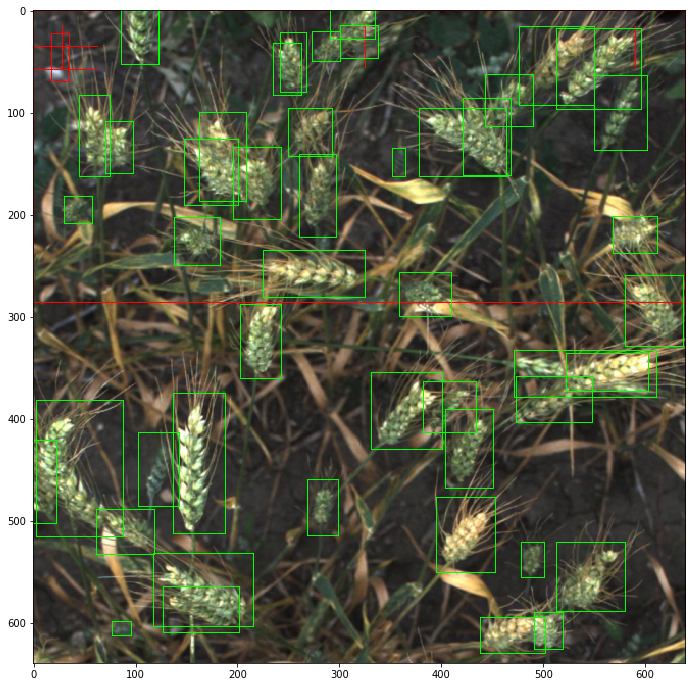

In [16]:
images, targets = batch
i = 0

image = images[i].clone()
true_boxes = targets['bbox'][i].clone()
pred_boxes = out['detections'][i][:, :4].clone()

for box in pred_boxes:
    draw_bbox(image, box, channel=0)

for box in true_boxes:
    draw_bbox(image, box, channel=1)

device = image.device

stats(image)
image *= torch.tensor(IMAGENET_DEFAULT_STD, device=device)[:, None, None]
image += torch.tensor(IMAGENET_DEFAULT_MEAN, device=device)[:, None, None]
image = image.clamp(0, 1)
stats(image)

save_image(image, '/media/dmitry/data/kek/zhopa.png', normalize=True)

image = (image * 255.).to(torch.uint8).permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(12, 12))
plt.imshow(image)

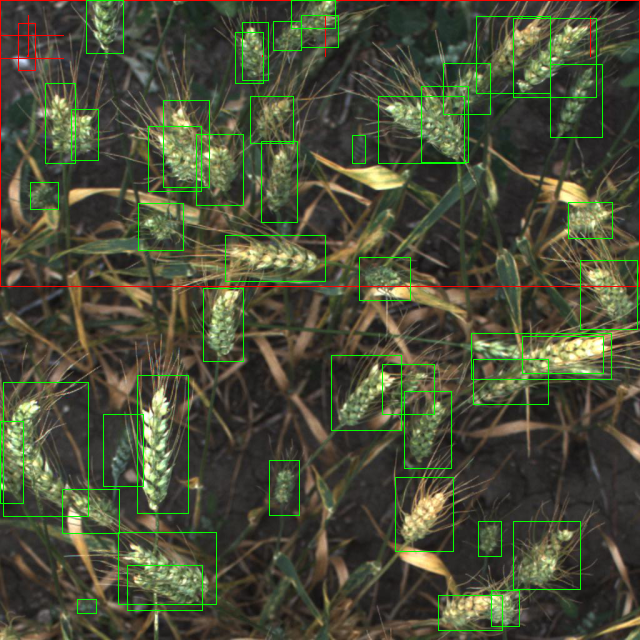

In [17]:
Image.open('/media/dmitry/data/kek/zhopa.png')